# Analyse reading times using information value

In [1]:
### Import and utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ast import literal_eval

# For local imports
import sys
sys.path.append('../../')
from utils import load_jsonl, load_surprise_data

# Plots
sns.set_palette('colorblind')
sns.set_style('white', {'font.family': 'Times New Roman'})
sns.set_context("paper", font_scale=2.5)

## Load data and preprocess

In [2]:
DATASETS = ['provo', 'ns', 'brown']

DATASET_CONTEXT_MAP = {
    'switchboard': 'switchboard/switchboard_results_is.jsonl',
    'dailydialog': 'dailydialog/dailydialog_results_is.jsonl',
    'BLL2018': 'BLL2018/processed_ratings.jsonl',
    'brown': 'RTs_5jun/brown_rt.jsonl',
    'ns': 'RTs_5jun/ns_rt.jsonl',
    'provo': 'RTs_5jun/provo_rt.jsonl',
}

CORPUS_NAMES = {
    'switchboard': 'Switchboard',
    'dailydialog': 'Dailydialog',
    'BLL2018': 'Clasp',
    'provo': 'Provo',
    'brown': 'Brown',
    'ns': 'Natural Stories',
}

MODEL_NAME_MAP = {
    'gpt2': 'GPT-2 Small',
    'gpt2-ft': 'GPT-2 Small Finetuned', # todo: remove
    'gpt2_medium': 'GPT-2 Medium',
    'gpt2-medium': 'GPT-2 Medium',
    'gpt2_large': 'GPT-2 Large',
    'gpt2-large': 'GPT-2 Large',
    'dialogpt_small': 'DialoGPT Small',
    'dialogpt-small': 'DialoGPT Small',
    'dialogpt_medium': 'DialoGPT Medium',
    'dialogpt-medium': 'DialoGPT Medium',
    'dialogpt_large': 'DialoGPT Large',
    'dialogpt-large': 'DialoGPT Large',
    'opt_125m': 'OPT 125M',
    'opt-125m': 'OPT 125M',
    'opt_350m': 'OPT 350M',
    'opt-350m': 'OPT 350M',
    'opt_1.3b': 'OPT 1.3B',
    'opt-1.3b': 'OPT 1.3B',
    'gpt_neo_125m': 'GPT-Neo 125M',
    'gpt-neo-125m': 'GPT-Neo 125M',
    'gpt_neo_1.3b': 'GPT-Neo 1.3B',
    'gpt-neo-1.3b': 'GPT-Neo 1.3B',
    'gpt-neo-1.3B': 'GPT-Neo 1.3B',
}

SAMPLING_PARAM_MAP = {
    "None": "None", "02": "0.2", "03": "0.3", "075": "0.75", "08": "0.8",
    "085": "0.85", "09": "0.9", "095": "0.95", "125": "1.25"
}


In [3]:
### Load data

dfs = []
for dataset in DATASETS:
    print(f"Loading data for {dataset}...")
    DATA_DIR = f"../../../data/surprise/{dataset}"

    df = load_surprise_data(DATA_DIR)

    # Prettify column and value names
    df["corpus"] = df["corpus"].map(CORPUS_NAMES)
    df["sampling"] = df["sampling"].str.capitalize()
    df["sampling"] = df["sampling"].str.replace("Temp", "Temperature")

    df["model"] = df["model"].map(MODEL_NAME_MAP)

    sampling_param_map = {
        "None": "None", "02": "0.2", "03": "0.3", "075": "0.75", "08": "0.8",
        "085": "0.85", "09": "0.9", "095": "0.95", "125": "1.25"
    }
    df["sampling_param"] = df["sampling_param"].map(sampling_param_map)

    dfs.append(df)

surprise = pd.concat(dfs, axis=0, ignore_index=True)

Loading data for provo...
Size of dataset: 119680 rows
Loading data for ns...
Size of dataset: 377720 rows
Loading data for brown...
Size of dataset: 396000 rows


In [4]:
# Add sentence length to dataframe

def _len(s):
    """
    Returns the length of a string or list of strings
    (dealing with different formats when we read json strings)
    """
    if not s:
        return 0
    assert(type(s) is str)
    return len(s.split())

mapping_len = {}
mapping_non_zero = {}
for dset in DATASETS:
    print(dset)
    # Load the context dataframe
    original_dataset = load_jsonl(f"../../../data/psychometric/{DATASET_CONTEXT_MAP[dset]}")
    df_original = pd.DataFrame(original_dataset)

    # # Deal with diff column names
    # if 'context_id' not in df_original.columns:
    #     df_original['context_id'] = df_original.id

    # Map context length based on (context_id, target_id)
    for _, row in df_original.iterrows():
        row_item_id = f"{row['text_id_']}_{row['sentence_num_']}"
        mapping_len[(row_item_id, CORPUS_NAMES[dset])] = _len(row['target'])
        mapping_non_zero[(row_item_id, CORPUS_NAMES[dset])] = row['time_count_nonzero_list_NO']

# Add the context_length column to df data
surprise['target_length'] = surprise.apply(
    lambda row: mapping_len.get((row['context_id'], row['corpus']), 0), axis=1
)
surprise['time_count_nonzero_list_NO'] = surprise.apply(
    lambda row: mapping_non_zero.get((row['context_id'], row['corpus']), 0), axis=1
)


provo
ns
brown


In [5]:
provo_one_df = surprise[
    (surprise['model'] == 'GPT-2 Small') &
    (surprise['corpus'] == 'Provo') &
    (surprise['sampling'] == 'Nucleus') &
    (surprise['sampling_param'] == '0.95') &
    (surprise['n_samples'] == 10)
]

ns_one_df = surprise[
    (surprise['model'] == 'GPT-Neo 125M') &
    (surprise['corpus'] == 'Natural Stories') &
    (surprise['sampling'] == 'Typical') &
    (surprise['sampling_param'] == '0.2') &
    (surprise['n_samples'] == 50)
]

brown_one_df = surprise[
    (surprise['model'] == 'GPT-2 Small') &
    (surprise['corpus'] == 'Brown') &
    (surprise['sampling'] == 'Typical') &
    (surprise['sampling_param'] == '0.3') &
    (surprise['n_samples'] == 90)
]

In [6]:
# One row per judgement
provo_one_df['time_sum_list_NO'] = provo_one_df['time_sum_list_NO'].apply(literal_eval)
provo_one_df = provo_one_df.explode(['time_sum_list_NO', 'time_count_nonzero_list_NO']).reset_index(drop=True)
provo_one_df['time_sum_list_NO'] = pd.to_numeric(provo_one_df['time_sum_list_NO'])
provo_one_df['time_count_nonzero_list_NO'] = pd.to_numeric(provo_one_df['time_count_nonzero_list_NO'])

ns_one_df['time_sum_list_NO'] = ns_one_df['time_sum_list_NO'].apply(literal_eval)
ns_one_df = ns_one_df.explode(['time_sum_list_NO', 'time_count_nonzero_list_NO']).reset_index(drop=True)
ns_one_df['time_sum_list_NO'] = pd.to_numeric(ns_one_df['time_sum_list_NO'])
ns_one_df['time_count_nonzero_list_NO'] = pd.to_numeric(ns_one_df['time_count_nonzero_list_NO'])

brown_one_df['time_sum_list_NO'] = brown_one_df['time_sum_list_NO'].apply(literal_eval)
brown_one_df = brown_one_df.explode(['time_sum_list_NO', 'time_count_nonzero_list_NO']).reset_index(drop=True)
brown_one_df['time_sum_list_NO'] = pd.to_numeric(brown_one_df['time_sum_list_NO'])
brown_one_df['time_count_nonzero_list_NO'] = pd.to_numeric(brown_one_df['time_count_nonzero_list_NO'])


/tmp/ipykernel_8279/2273495921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  provo_one_df['time_sum_list_NO'] = provo_one_df['time_sum_list_NO'].apply(literal_eval)
/tmp/ipykernel_8279/2273495921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ns_one_df['time_sum_list_NO'] = ns_one_df['time_sum_list_NO'].apply(literal_eval)
/tmp/ipykernel_8279/2273495921.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

## Statistical models

In [7]:
from statsmodels.formula.api import mixedlm

def get_mixedlm_results(data_df, y, X, group, baseline_rdict=None, nan_policy='fill'):
    """
    Fit a mixed linear model with y as the response variable and X as the predictor variables.
    The model is fit with group as a random effect.

    :param data_df: Dataframe containing estimates and psychometric data
    :param y: Response variable (a string)
    :param X: Predictor variables (a list of strings)
    :param group: Group variable (a string)
    :param baseline_rdict: Dictionary containing results of a baseline model (as returned by this function)
    :param nan_policy: How to handle NaN values in the data. Either 'omit' or 'fill'.
    :return: Tuple containing the model results (a statsmodel object) and a dictionary of results
    """
    if nan_policy == 'omit':
        data_df = data_df.dropna(subset=X)
    elif nan_policy == 'fill':
        data_df = data_df.fillna(1.0)
    else:
        raise ValueError(f"Invalid nan_policy: {nan_policy}")

    formula = f"{y} ~ {' + '.join([x for x in ['1'] + X])}"

    model = mixedlm(
        formula,
        data_df,
        groups=data_df[group]
    )

    result = model.fit(method=["bfgs"])
    result_dict = {}

    tvals = result.tvalues.to_dict()
    for k in tvals:
        if k != "Group Var":
            result_dict[f"Coeff {k}"] = tvals[k]

    pvals = result.pvalues.to_dict()
    for k in pvals:
        if k != "Group Var":
            result_dict[f"p-value {k}"] = pvals[k]

    result_dict["Group Var"] = tvals["Group Var"]
    result_dict["Residual Var"] = result.scale
    result_dict["Total Var"] = result_dict["Residual Var"] + result_dict["Group Var"]
    result_dict["Explained Var"] = result_dict["Group Var"] / result_dict["Total Var"]
    result_dict["Log-Likelihood"] = result.llf
    result_dict["Converged"] = result.converged

    if baseline_rdict:
        result_dict["Delta Log-Likelihood"] = result_dict["Log-Likelihood"] - baseline_rdict["Log-Likelihood"]

    return result, result_dict

In [8]:
def get_single_predictor_results(single_predictor_models):
    # First, get the coefficients, p-values, and deltas.
    coefficients = []
    p_values = []
    deltas = []
    _metrics = []
    for metric in single_predictor_models:
        _metrics.append(metric)
        coefficients.append(single_predictor_models[metric][f'Coeff {metric}'])
        p_values.append(single_predictor_models[metric][f'p-value {metric}'])
        deltas.append(single_predictor_models[metric]['Delta Log-Likelihood'])

    # Then, make a dataframe.
    single_predictor_df = pd.DataFrame({
        'Metric': _metrics,
        'Coefficient': coefficients,
        'Delta Log-Likelihood': deltas,
        'p-value': p_values,
    })

    # Round coefficients and deltas to 3 decimal places.
    single_predictor_df['Coefficient'] = single_predictor_df['Coefficient'].apply(lambda x: round(x, 3))
    single_predictor_df['Delta Log-Likelihood'] = single_predictor_df['Delta Log-Likelihood'].apply(lambda x: round(x, 3))

    # Make a latex table using coefficients, p-values, and deltas. Add a star to coefficient if p-value < 0.001.
    single_predictor_df['Coefficient'] = single_predictor_df.apply(lambda x: f"{x['Coefficient']}{'*' if x['p-value'] < 0.01 else ''}{'*' if x['p-value'] < 0.001 else ''}", axis=1)

    # print table without p-values, rounded to 3 decimal places
    print(single_predictor_df[['Metric', 'Coefficient', 'Delta Log-Likelihood']].to_latex(index=False, float_format="%.3f"))

    return single_predictor_df


In [9]:
def plot_single_predictor_results(single_predictor_df):
    fig, ax = plt.subplots(figsize=(13, 5))
    sns.barplot(
        data=pd.DataFrame({
            "Metric": single_predictor_df['Metric'],
            "Delta Log-Likelihood": single_predictor_df['Delta Log-Likelihood']
        }),
        x="Metric",
        y="Delta Log-Likelihood",
        ax=ax
    )

    ax.set_xlabel("")
    ax.set_ylabel("$\Delta$ Log-Likelihood")
    # rotate x tick labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

In [10]:
all_single_predictors = [
    'surprise_mean_1gram', 'surprise_mean_2gram', 'surprise_mean_3gram',
    'surprise_mean_1gram_pos', 'surprise_mean_2gram_pos', 'surprise_mean_3gram_pos',
    'surprise_mean_cosine', 'surprise_mean_euclidean',
    'surprise_min_1gram', 'surprise_min_2gram', 'surprise_min_3gram',
    'surprise_min_1gram_pos', 'surprise_min_2gram_pos', 'surprise_min_3gram_pos',
    'surprise_min_cosine', 'surprise_min_euclidean',
    'surprise_ooc_mean_1gram', 'surprise_ooc_mean_2gram', 'surprise_ooc_mean_3gram',
    'surprise_ooc_mean_1gram_pos', 'surprise_ooc_mean_2gram_pos', 'surprise_ooc_mean_3gram_pos',
    'surprise_ooc_mean_cosine', 'surprise_ooc_mean_euclidean',
    'surprise_ooc_min_1gram', 'surprise_ooc_min_2gram', 'surprise_ooc_min_3gram',
    'surprise_ooc_min_1gram_pos', 'surprise_ooc_min_2gram_pos', 'surprise_ooc_min_3gram_pos',
    'surprise_ooc_min_cosine', 'surprise_ooc_min_euclidean'
]
response_var = "time_sum_list_NO"
control_predictors = ["time_count_nonzero_list_NO"]

-----

## Provo

### Baseline model

In [11]:
provo_baseline_result, provo_baseline_rdict = get_mixedlm_results(
    provo_one_df,
    y=response_var,
    X=control_predictors,
    group='context_id'
)
print(provo_baseline_result.summary())

                    Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      time_sum_list_NO
No. Observations:       10744        Method:                  REML            
No. Groups:             136          Scale:                   736266.0690     
Min. group size:        53           Log-Likelihood:          -88035.5687     
Max. group size:        84           Converged:               Yes             
Mean group size:        79.0                                                  
------------------------------------------------------------------------------
                             Coef.    Std.Err.    z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------
Intercept                    -703.878   58.089 -12.117 0.000 -817.730 -590.027
time_count_nonzero_list_NO    341.439    2.946 115.894 0.000  335.665  347.213
Group Var                  249322.512   41.045                           

### Single predictor models

In [12]:
single_predictor_models = {}
for metric in tqdm(all_single_predictors):
    _, tmp_rdict = get_mixedlm_results(
        provo_one_df,
        y=response_var,
        X=control_predictors + [metric],
        group='context_id',
        baseline_rdict=provo_baseline_rdict
    )
    single_predictor_models[metric] = tmp_rdict


  0%|          | 0/32 [00:00<?, ?it/s]

In [13]:
single_predictor_df = get_single_predictor_results(single_predictor_models)

\begin{tabular}{llr}
\toprule
Metric & Coefficient & Delta Log-Likelihood \\
\midrule
surprise_mean_1gram & 2.31 & 9.967 \\
surprise_mean_2gram & 1.977 & 10.971 \\
surprise_mean_3gram & 1.982 & 12.169 \\
surprise_mean_1gram_pos & 1.902 & 8.413 \\
surprise_mean_2gram_pos & 3.814** & 13.861 \\
surprise_mean_3gram_pos & 5.528** & 21.798 \\
surprise_mean_cosine & 0.238 & 6.661 \\
surprise_mean_euclidean & 0.221 & 6.864 \\
surprise_min_1gram & 2.219 & 9.649 \\
surprise_min_2gram & 1.882 & 9.490 \\
surprise_min_3gram & 1.997 & 10.337 \\
surprise_min_1gram_pos & 5.45** & 21.187 \\
surprise_min_2gram_pos & 4.494** & 16.292 \\
surprise_min_3gram_pos & 4.957** & 18.394 \\
surprise_min_cosine & 0.548 & 6.476 \\
surprise_min_euclidean & 0.507 & 6.567 \\
surprise_ooc_mean_1gram & 2.202 & 10.545 \\
surprise_ooc_mean_2gram & 1.608 & 11.790 \\
surprise_ooc_mean_3gram & 0.781 & 12.961 \\
surprise_ooc_mean_1gram_pos & 2.864* & 11.661 \\
surprise_ooc_mean_2gram_pos & 5.495** & 21.930 \\
surprise_ooc_mean

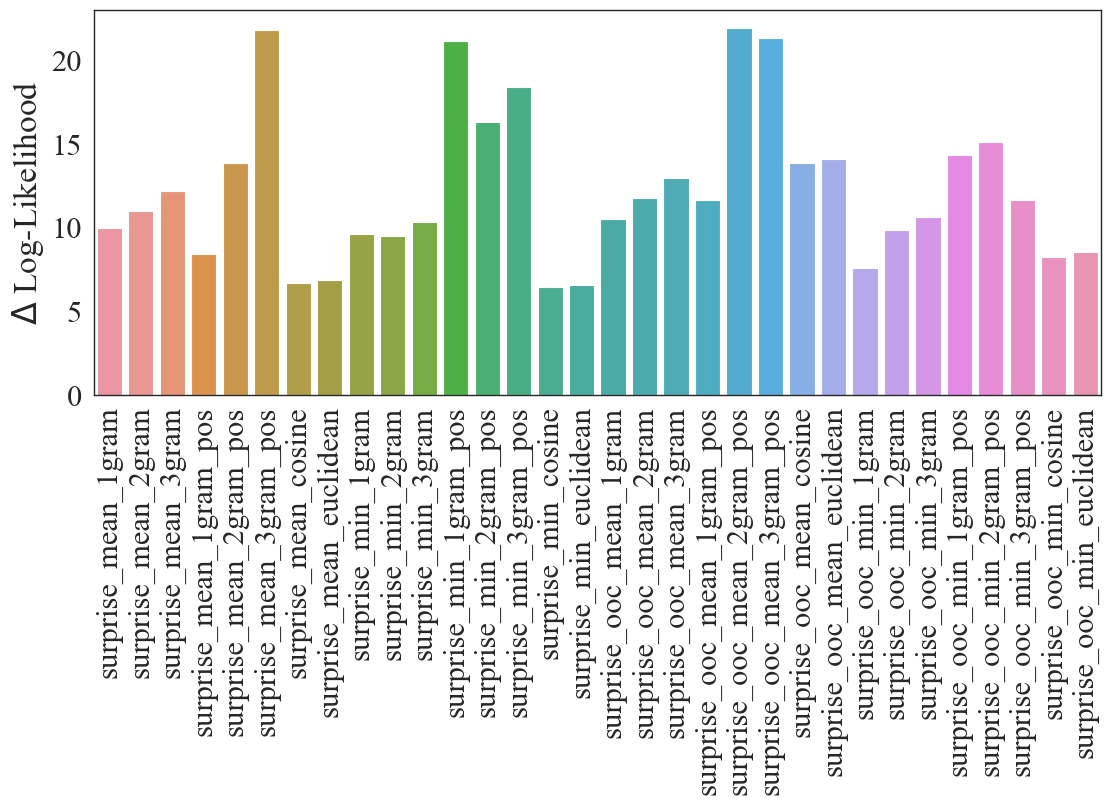

In [14]:
plot_single_predictor_results(single_predictor_df)

### Aggregate predictor models


In [15]:

# Pick the best features in and out of context
metric_dll_df = single_predictor_df[['Metric', 'Delta Log-Likelihood']]

CONTEXT_CONDS = ['In context', 'Out of context']
FEATURES = ['Syntactic', 'Lexical', 'Semantic']

def feature_type(x):
    if 'pos' in x:
        return FEATURES[0]
    elif 'gram' in x:
        return FEATURES[1]
    else:
        return FEATURES[2]

metric_dll_df['Context Condition'] = metric_dll_df['Metric'].apply(lambda x : CONTEXT_CONDS[1] if 'ooc' in x else CONTEXT_CONDS[0])
metric_dll_df['Feature Type'] = metric_dll_df['Metric'].apply(lambda x : feature_type(x))

best_preds = {c: {} for c in CONTEXT_CONDS}
for cond in CONTEXT_CONDS:
    for feat in FEATURES:
        df = metric_dll_df[(metric_dll_df['Context Condition'] == cond) & (metric_dll_df['Feature Type'] == feat)]
        best_preds[cond][feat] = list(df[df['Delta Log-Likelihood'] == df['Delta Log-Likelihood'].max()]['Metric'])[0]

display(best_preds)


/tmp/ipykernel_8279/2128364471.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_dll_df['Context Condition'] = metric_dll_df['Metric'].apply(lambda x : CONTEXT_CONDS[1] if 'ooc' in x else CONTEXT_CONDS[0])


{'In context': {'Syntactic': 'surprise_mean_3gram_pos',
  'Lexical': 'surprise_mean_3gram',
  'Semantic': 'surprise_mean_euclidean'},
 'Out of context': {'Syntactic': 'surprise_ooc_mean_2gram_pos',
  'Lexical': 'surprise_ooc_mean_3gram',
  'Semantic': 'surprise_ooc_mean_euclidean'}}

In [17]:
# Take the best features directly from the best primary features for [for SURPRISE, OOC_SURPRISE, EXPECTED_SURPRISE, DEVIATION_SURPRISE, CONTEXT_INFO]
measures = {
    'mean_surprise': ['surprise_mean_3gram', 'surprise_mean_3gram_pos', 'surprise_mean_cosine'],
    'min_surprise': ['surprise_min_1gram', 'surprise_min_3gram_pos', 'surprise_min_cosine'],
    'ooc_mean_surprise': ['surprise_ooc_mean_1gram', 'surprise_ooc_mean_3gram_pos', 'surprise_ooc_mean_euclidean'],
    'ooc_min_surprise': ['surprise_ooc_min_1gram', 'surprise_ooc_min_3gram_pos', 'surprise_ooc_min_cosine'],
#     'expected_surprise': ['expected_surprise_3gram', 'expected_surprise_3gram_pos', 'expected_surprise_cosine'],
#     'deviation_surprise': ['surprise_deviation_3gram', 'surprise_deviation_3gram_pos', 'surprise_deviation_cosine'],
#     'context_informativeness': ['context_informativeness_3gram', 'context_informativeness_3gram_pos', 'context_informativeness_cosine'],
    'surprise' : [v for k,v in best_preds['In context'].items()],
    'ooc_surprise' : [v for k,v in best_preds['Out of context'].items()],
    'expected_surprise': ['expected_surprise_'+'_'.join(v.split('_')[2:]) for k,v in best_preds['In context'].items()],
    'deviation_surprise': ['surprise_deviation_'+'_'.join(v.split('_')[2:]) for k,v in best_preds['In context'].items()],
    'context_informativeness': ['context_informativeness_'+'_'.join(v.split('_')[2:]) for k,v in best_preds['In context'].items()],
}

measures_dicts = {}
for m, Xs in measures.items():
    print(m, Xs)
    try:
        _, rdict = get_mixedlm_results(
            provo_one_df,
            y=response_var,
            X=control_predictors + Xs,
            group='context_id',
            baseline_rdict=provo_baseline_rdict
        )
        measures_dicts[m] = rdict
    except:
        print('Error:')
        pass
    
    
# Convert to a dataframe for plotting
measures_df = pd.DataFrame.from_dict(measures_dicts).T
measures_df['Measure'] = measures_df.index
measures_df = measures_df.reset_index(drop=True)
measures_df[['Measure', 'Delta Log-Likelihood']]
measures_df['Distances'] = measures_df['Measure'].apply(lambda x: measures[x])
measures_df['Distances'] = measures_df['Measure'].apply(lambda x: measures[x])


mean_surprise ['surprise_mean_3gram', 'surprise_mean_3gram_pos', 'surprise_mean_cosine']
min_surprise ['surprise_min_1gram', 'surprise_min_3gram_pos', 'surprise_min_cosine']
ooc_mean_surprise ['surprise_ooc_mean_1gram', 'surprise_ooc_mean_3gram_pos', 'surprise_ooc_mean_euclidean']
ooc_min_surprise ['surprise_ooc_min_1gram', 'surprise_ooc_min_3gram_pos', 'surprise_ooc_min_cosine']
surprise ['surprise_mean_3gram_pos', 'surprise_mean_3gram', 'surprise_mean_euclidean']
ooc_surprise ['surprise_ooc_mean_2gram_pos', 'surprise_ooc_mean_3gram', 'surprise_ooc_mean_euclidean']
expected_surprise ['expected_surprise_3gram_pos', 'expected_surprise_3gram', 'expected_surprise_euclidean']
deviation_surprise ['surprise_deviation_3gram_pos', 'surprise_deviation_3gram', 'surprise_deviation_euclidean']
context_informativeness ['context_informativeness_3gram_pos', 'context_informativeness_3gram', 'context_informativeness_euclidean']


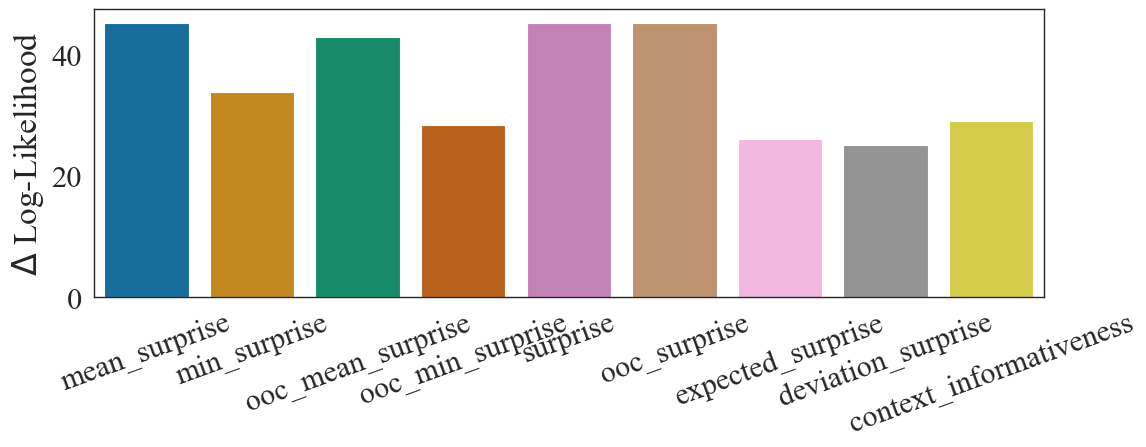

In [18]:
# Plot
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(
    data = measures_df,
    x="Measure",
    y="Delta Log-Likelihood",
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("$\Delta$ Log-Likelihood")
# rotate x tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(20)

plt.tight_layout()


In [19]:
# Save results
measures_df.to_csv('dataframes/provo_measures.csv')


-----

## Natural stories

### Baseline model

In [20]:
ns_baseline_result, ns_baseline_rdict = get_mixedlm_results(
    ns_one_df,
    y=response_var,
    X=control_predictors,
    group='context_id'
)
print(ns_baseline_result.summary())

                   Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     time_sum_list_NO
No. Observations:      36109       Method:                 REML            
No. Groups:            497         Scale:                  3442305.2298    
Min. group size:       33          Log-Likelihood:         -323185.3654    
Max. group size:       93          Converged:              Yes             
Mean group size:       72.7                                                
---------------------------------------------------------------------------
                             Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------
Intercept                    108.581   30.639   3.544 0.000  48.530 168.631
time_count_nonzero_list_NO   307.428    1.347 228.164 0.000 304.787 310.069
Group Var                  61002.405    3.856                              



### Single predictor models

In [ ]:
single_predictor_models = {}
for metric in tqdm(all_single_predictors):
    _, tmp_rdict = get_mixedlm_results(
        ns_one_df,
        y=response_var,
        X=control_predictors + [metric],
        group='context_id',
        baseline_rdict=ns_baseline_rdict
    )
    single_predictor_models[metric] = tmp_rdict


  0%|          | 0/32 [00:00<?, ?it/s]

    ### Single predictor models

In [ ]:
single_predictor_df = get_single_predictor_results(single_predictor_models)

In [ ]:
plot_single_predictor_results(single_predictor_df)

### Aggregate predictor models



In [ ]:
# Pick the best features in and out of context
metric_dll_df = single_predictor_df[['Metric', 'Delta Log-Likelihood']]

CONTEXT_CONDS = ['In context', 'Out of context']
FEATURES = ['Syntactic', 'Lexical', 'Semantic']

def feature_type(x):
    if 'pos' in x:
        return FEATURES[0]
    elif 'gram' in x:
        return FEATURES[1]
    else:
        return FEATURES[2]

metric_dll_df['Context Condition'] = metric_dll_df['Metric'].apply(lambda x : CONTEXT_CONDS[1] if 'ooc' in x else CONTEXT_CONDS[0])
metric_dll_df['Feature Type'] = metric_dll_df['Metric'].apply(lambda x : feature_type(x))

best_preds = {c: {} for c in CONTEXT_CONDS}
for cond in CONTEXT_CONDS:
    for feat in FEATURES:
        df = metric_dll_df[(metric_dll_df['Context Condition'] == cond) & (metric_dll_df['Feature Type'] == feat)]
        best_preds[cond][feat] = list(df[df['Delta Log-Likelihood'] == df['Delta Log-Likelihood'].max()]['Metric'])[0]

display(best_preds)


In [ ]:
# Take the best features directly from the best primary features for [for SURPRISE, OOC_SURPRISE, EXPECTED_SURPRISE, DEVIATION_SURPRISE, CONTEXT_INFO]
measures = {
    'mean_surprise': ['surprise_mean_3gram', 'surprise_mean_3gram_pos', 'surprise_mean_cosine'],
    'min_surprise': ['surprise_min_1gram', 'surprise_min_3gram_pos', 'surprise_min_cosine'],
    'ooc_mean_surprise': ['surprise_ooc_mean_1gram', 'surprise_ooc_mean_3gram_pos', 'surprise_ooc_mean_euclidean'],
    'ooc_min_surprise': ['surprise_ooc_min_1gram', 'surprise_ooc_min_3gram_pos', 'surprise_ooc_min_cosine'],
#     'expected_surprise': ['expected_surprise_3gram', 'expected_surprise_3gram_pos', 'expected_surprise_cosine'],
#     'deviation_surprise': ['surprise_deviation_3gram', 'surprise_deviation_3gram_pos', 'surprise_deviation_cosine'],
#     'context_informativeness': ['context_informativeness_3gram', 'context_informativeness_3gram_pos', 'context_informativeness_cosine'],
    'surprise' : [v for k,v in best_preds['In context'].items()],
    'ooc_surprise' : [v for k,v in best_preds['Out of context'].items()],
    'expected_surprise': ['expected_surprise_'+'_'.join(v.split('_')[2:]) for k,v in best_preds['In context'].items()],
    'deviation_surprise': ['surprise_deviation_'+'_'.join(v.split('_')[2:]) for k,v in best_preds['In context'].items()],
    'context_informativeness': ['context_informativeness_'+'_'.join(v.split('_')[2:]) for k,v in best_preds['In context'].items()],
}

measures_dicts = {}
for m, Xs in measures.items():
    print(m, Xs)
    try:
        _, rdict = get_mixedlm_results(
            ns_one_df,
            y=response_var,
            X=control_predictors + Xs,
            group='context_id',
            baseline_rdict=ns_baseline_rdict
        )
        measures_dicts[m] = rdict
    except:
        print('Error:')
        pass
    
    
# Convert to a dataframe for plotting
measures_df = pd.DataFrame.from_dict(measures_dicts).T
measures_df['Measure'] = measures_df.index
measures_df = measures_df.reset_index(drop=True)
measures_df[['Measure', 'Delta Log-Likelihood']]
measures_df['Distances'] = measures_df['Measure'].apply(lambda x: measures[x])


In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(
    data = measures_df,
    x="Measure",
    y="Delta Log-Likelihood",
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("$\Delta$ Log-Likelihood")
# rotate x tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(20)

plt.tight_layout()


In [ ]:
# Save results
measures_df.to_csv('dataframes/ns_measures.csv')


-----

## Brown

### Baseline model

In [21]:
brown_baseline_result, brown_baseline_rdict = get_mixedlm_results(
    brown_one_df,
    y=response_var,
    X=control_predictors,
    group='context_id'
)
print(brown_baseline_result.summary())

                   Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     time_sum_list_NO
No. Observations:      7423        Method:                 REML            
No. Groups:            450         Scale:                  1809403.7814    
Min. group size:       5           Log-Likelihood:         -64096.3902     
Max. group size:       24          Converged:              Yes             
Mean group size:       16.5                                                
---------------------------------------------------------------------------
                             Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------
Intercept                      6.559   35.786   0.183 0.855 -63.580  76.698
time_count_nonzero_list_NO   297.412    1.945 152.898 0.000 293.600 301.225
Group Var                  56547.872    8.960                              



### Single predictor models

In [22]:
single_predictor_models = {}
for metric in tqdm(all_single_predictors):
    _, tmp_rdict = get_mixedlm_results(
        brown_one_df,
        y=response_var,
        X=control_predictors + [metric],
        group='context_id',
        baseline_rdict=brown_baseline_rdict
    )
    single_predictor_models[metric] = tmp_rdict


  0%|          | 0/32 [00:00<?, ?it/s]

In [23]:
single_predictor_df = get_single_predictor_results(single_predictor_models)

\begin{tabular}{llr}
\toprule
Metric & Coefficient & Delta Log-Likelihood \\
\midrule
surprise_mean_1gram & 2.409 & 9.679 \\
surprise_mean_2gram & 1.622 & 9.076 \\
surprise_mean_3gram & 1.891 & 11.974 \\
surprise_mean_1gram_pos & 0.958 & 6.627 \\
surprise_mean_2gram_pos & 1.331 & 7.291 \\
surprise_mean_3gram_pos & 1.475 & 8.194 \\
surprise_mean_cosine & 0.714 & 6.633 \\
surprise_mean_euclidean & 0.766 & 6.833 \\
surprise_min_1gram & 2.39 & 9.059 \\
surprise_min_2gram & 2.121 & 8.426 \\
surprise_min_3gram & 3.688** & 13.913 \\
surprise_min_1gram_pos & 1.947 & 8.633 \\
surprise_min_2gram_pos & 1.404 & 6.854 \\
surprise_min_3gram_pos & 1.362 & 6.706 \\
surprise_min_cosine & 0.661 & 6.164 \\
surprise_min_euclidean & 0.699 & 6.020 \\
surprise_ooc_mean_1gram & -0.276 & 7.393 \\
surprise_ooc_mean_2gram & 0.995 & 10.767 \\
surprise_ooc_mean_3gram & 1.035 & 12.401 \\
surprise_ooc_mean_1gram_pos & -1.583 & 8.368 \\
surprise_ooc_mean_2gram_pos & 0.787 & 7.496 \\
surprise_ooc_mean_3gram_pos & 2.59

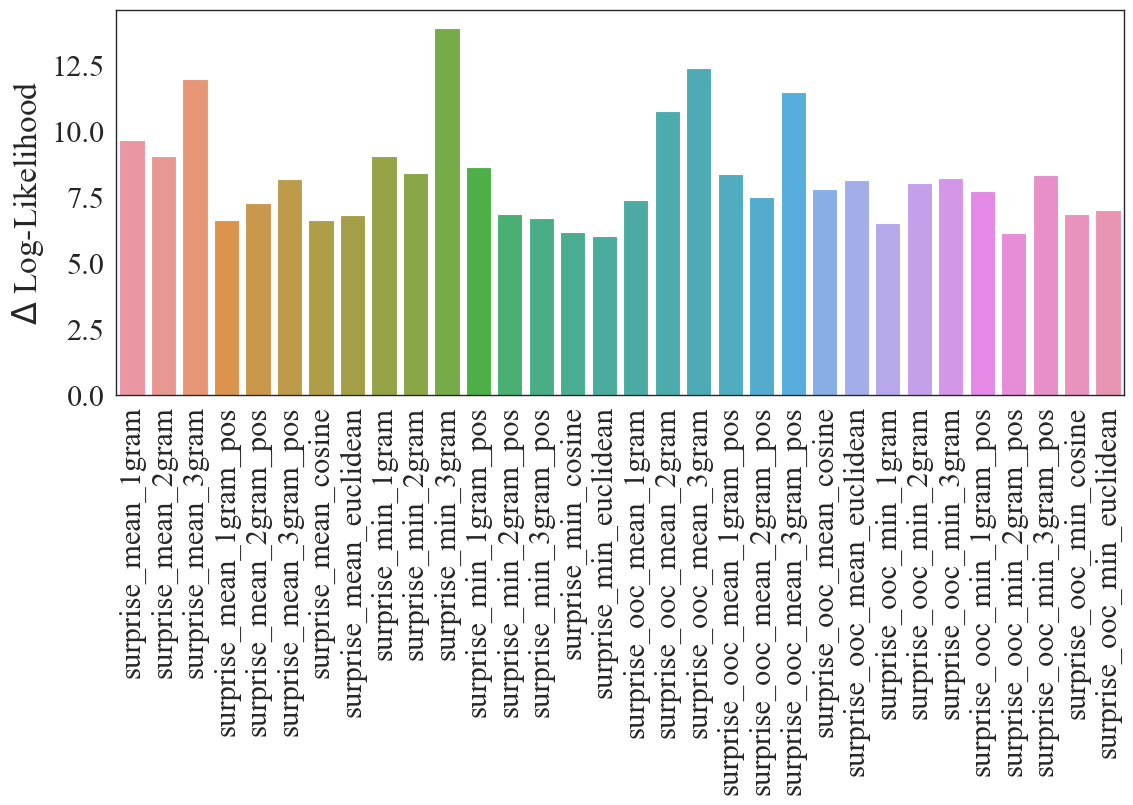

In [24]:
plot_single_predictor_results(single_predictor_df)

### Aggregate predictor models

In [25]:
# Pick the best features in and out of context
metric_dll_df = single_predictor_df[['Metric', 'Delta Log-Likelihood']]

CONTEXT_CONDS = ['In context', 'Out of context']
FEATURES = ['Syntactic', 'Lexical', 'Semantic']

def feature_type(x):
    if 'pos' in x:
        return FEATURES[0]
    elif 'gram' in x:
        return FEATURES[1]
    else:
        return FEATURES[2]

metric_dll_df['Context Condition'] = metric_dll_df['Metric'].apply(lambda x : CONTEXT_CONDS[1] if 'ooc' in x else CONTEXT_CONDS[0])
metric_dll_df['Feature Type'] = metric_dll_df['Metric'].apply(lambda x : feature_type(x))

best_preds = {c: {} for c in CONTEXT_CONDS}
for cond in CONTEXT_CONDS:
    for feat in FEATURES:
        df = metric_dll_df[(metric_dll_df['Context Condition'] == cond) & (metric_dll_df['Feature Type'] == feat)]
        best_preds[cond][feat] = list(df[df['Delta Log-Likelihood'] == df['Delta Log-Likelihood'].max()]['Metric'])[0]

display(best_preds)


/tmp/ipykernel_30368/2127762814.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_dll_df['Context Condition'] = metric_dll_df['Metric'].apply(lambda x : CONTEXT_CONDS[1] if 'ooc' in x else CONTEXT_CONDS[0])


{'In context': {'Syntactic': 'surprise_min_1gram_pos',
  'Lexical': 'surprise_min_3gram',
  'Semantic': 'surprise_mean_euclidean'},
 'Out of context': {'Syntactic': 'surprise_ooc_mean_3gram_pos',
  'Lexical': 'surprise_ooc_mean_3gram',
  'Semantic': 'surprise_ooc_mean_euclidean'}}

In [26]:
# Take the best features directly from the best primary features for [for SURPRISE, OOC_SURPRISE, EXPECTED_SURPRISE, DEVIATION_SURPRISE, CONTEXT_INFO]
measures = {
    'mean_surprise': ['surprise_mean_3gram', 'surprise_mean_3gram_pos', 'surprise_mean_cosine'],
    'min_surprise': ['surprise_min_1gram', 'surprise_min_3gram_pos', 'surprise_min_cosine'],
    'ooc_mean_surprise': ['surprise_ooc_mean_1gram', 'surprise_ooc_mean_3gram_pos', 'surprise_ooc_mean_euclidean'],
    'ooc_min_surprise': ['surprise_ooc_min_1gram', 'surprise_ooc_min_3gram_pos', 'surprise_ooc_min_cosine'],
#     'expected_surprise': ['expected_surprise_3gram', 'expected_surprise_3gram_pos', 'expected_surprise_cosine'],
#     'deviation_surprise': ['surprise_deviation_3gram', 'surprise_deviation_3gram_pos', 'surprise_deviation_cosine'],
#     'context_informativeness': ['context_informativeness_3gram', 'context_informativeness_3gram_pos', 'context_informativeness_cosine'],
    'surprise' : [v for k,v in best_preds['In context'].items()],
    'ooc_surprise' : [v for k,v in best_preds['Out of context'].items()],
    'expected_surprise': ['expected_surprise_'+'_'.join(v.split('_')[2:]) for k,v in best_preds['In context'].items()],
    'deviation_surprise': ['surprise_deviation_'+'_'.join(v.split('_')[2:]) for k,v in best_preds['In context'].items()],
    'context_informativeness': ['context_informativeness_'+'_'.join(v.split('_')[2:]) for k,v in best_preds['In context'].items()],
}

measures_dicts = {}
for m, Xs in measures.items():
    print(m, Xs)
    try:
        _, rdict = get_mixedlm_results(
            brown_one_df,
            y=response_var,
            X=control_predictors + Xs,
            group='context_id',
            baseline_rdict=brown_baseline_rdict
        )
        measures_dicts[m] = rdict
    except:
        print('Error:')
        pass
    
    
# Convert to a dataframe for plotting
measures_df = pd.DataFrame.from_dict(measures_dicts).T
measures_df['Measure'] = measures_df.index
measures_df = measures_df.reset_index(drop=True)
measures_df[['Measure', 'Delta Log-Likelihood']]



mean_surprise ['surprise_mean_3gram', 'surprise_mean_3gram_pos', 'surprise_mean_cosine']
min_surprise ['surprise_min_1gram', 'surprise_min_3gram_pos', 'surprise_min_cosine']
ooc_mean_surprise ['surprise_ooc_mean_1gram', 'surprise_ooc_mean_3gram_pos', 'surprise_ooc_mean_euclidean']
ooc_min_surprise ['surprise_ooc_min_1gram', 'surprise_ooc_min_3gram_pos', 'surprise_ooc_min_cosine']
surprise ['surprise_min_1gram_pos', 'surprise_min_3gram', 'surprise_mean_euclidean']
ooc_surprise ['surprise_ooc_mean_3gram_pos', 'surprise_ooc_mean_3gram', 'surprise_ooc_mean_euclidean']
expected_surprise ['expected_surprise_1gram_pos', 'expected_surprise_3gram', 'expected_surprise_euclidean']
deviation_surprise ['surprise_deviation_1gram_pos', 'surprise_deviation_3gram', 'surprise_deviation_euclidean']
context_informativeness ['context_informativeness_1gram_pos', 'context_informativeness_3gram', 'context_informativeness_euclidean']


,Measure,Delta Log-Likelihood
0,mean_surprise,26.357871
1,min_surprise,21.369342
2,ooc_mean_surprise,27.493234
3,ooc_min_surprise,21.988696
4,surprise,28.376523
5,ooc_surprise,31.688649
6,expected_surprise,22.167781
7,deviation_surprise,19.42789
8,context_informativeness,20.823134


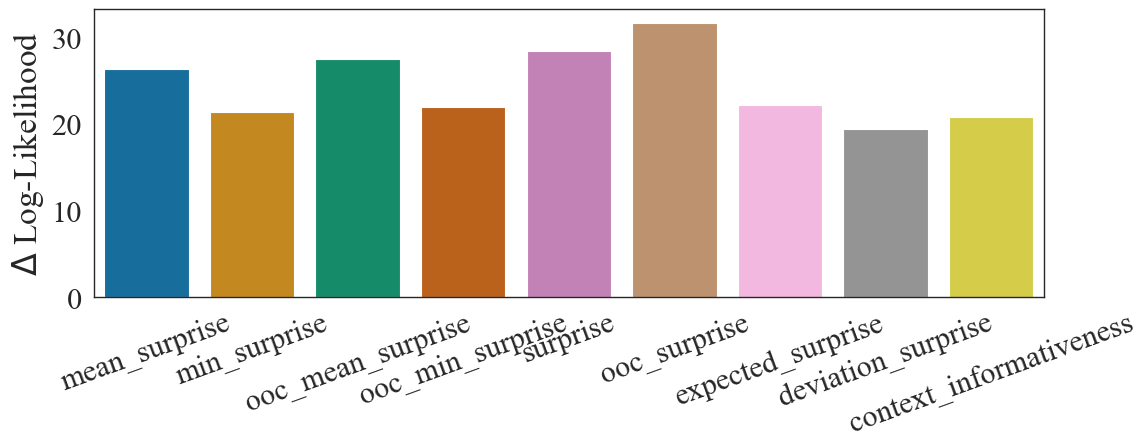

In [27]:
# Plot
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(
    data = measures_df,
    x="Measure",
    y="Delta Log-Likelihood",
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("$\Delta$ Log-Likelihood")
# rotate x tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(20)

plt.tight_layout()


In [28]:
# Save results
measures_df.to_csv('dataframes/brown_measures.csv')
